In [1]:
# Install necessary image loading/processing packages for the application
!python -c "import PIL" || pip install -q "Pillow"
!python -c "import skimage" || pip install -q "scikit-image"

# Install MONAI Deploy App SDK package
!python -c "import monai.deploy" || pip install -q "monai-deploy-app-sdk"

100% [........................................................] 205523 / 205523Test input file path: /tmp/normal-brain-mri-4.png


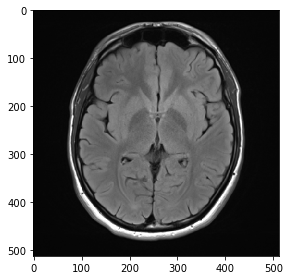

In [24]:

!python -c "import wget" || pip install -q "wget"

from skimage import io
import wget

test_input_path = "/tmp/normal-brain-mri-4.png"
wget.download("https://user-images.githubusercontent.com/1928522/133383228-2357d62d-316c-46ad-af8a-359b56f25c87.png", test_input_path)

print(f"Test input file path: {test_input_path}")

test_image = io.imread(test_input_path)
io.imshow(test_image)

In [25]:
import monai.deploy.core as md  # 'md' stands for MONAI Deploy (or can use 'core' instead)
from monai.deploy.core import (
    Application,
    DataPath,
    ExecutionContext,
    Image,
    InputContext,
    IOType,
    Operator,
    OutputContext,
)

In [26]:
#input and output are used after MD decorator which is @ 
@md.input("image", DataPath, IOType.DISK)
@md.output("image", Image, IOType.IN_MEMORY)
class GaussianOperator(Operator):
    """This Operator implements a smoothening based on Gaussian.

    It ingests a single input and provides a single output.
    """

    def compute(self, op_input: InputContext, op_output: OutputContext, context: ExecutionContext):
        from skimage.filters import gaussian
        from skimage.io import imsave

        data_in = op_input.get().asnumpy()
        data_out = gaussian(data_in, sigma=0.2)

        output_folder = op_output.get().path
        output_path = output_folder / "final_output.png"
        imsave(output_path, data_out)

In [27]:
@md.input("image", Image, IOType.IN_MEMORY)
@md.output("image", Image, IOType.IN_MEMORY)
# If `pip_packages` is specified, the definition will be aggregated with the package dependency list of other
# operators and the application in packaging time.
# @md.env(pip_packages=["scikit-image >= 0.17.2"])
class MedianOperator(Operator):
    """This Operator implements a noise reduction.

    The algorithm is based on the median operator.
    It ingests a single input and provides a single output.
    """

    def compute(self, op_input: InputContext, op_output: OutputContext, context: ExecutionContext):
        from skimage.filters import median

        data_in = op_input.get().asnumpy()
        data_out = median(data_in)
        op_output.set(Image(data_out))

In [28]:
@md.input("image", DataPath, IOType.DISK)
@md.output("image", Image, IOType.IN_MEMORY)
# If `pip_packages` is specified, the definition will be aggregated with the package dependency list of other
# operators and the application in packaging time.
# @md.env(pip_packages=["scikit-image >= 0.17.2"])
class SobelOperator(Operator):
    """This Operator implements a Sobel edge detector.

    It has a single input and single output.
    """

    def compute(self, op_input: InputContext, op_output: OutputContext, context: ExecutionContext):
        from skimage import filters, io

        input_path = op_input.get().path
        if input_path.is_dir():
            input_path = next(input_path.glob("*.*"))  # take the first file

        data_in = io.imread(input_path)[:, :, :3]  # discard alpha channel if exists
        data_out = filters.sobel(data_in)

        op_output.set(Image(data_out))

In [29]:
@md.resource(cpu=1)
# pip_packages can be a string that is a path(str) to requirements.txt file or a list of packages.
@md.env(pip_packages=["scikit-image >= 0.17.2"])
class App(Application):
    """This is a very basic application.

    This showcases the MONAI Deploy application framework.
    """

    # App's name. <class name>('App') if not specified.
    name = "simple_imaging_app"
    # App's description. <class docstring> if not specified.
    description = "This is a very simple application."
    # App's version. <git version tag> or '0.0.0' if not specified.
    version = "0.1.0"

    def compose(self):
        """This application has three operators.

        Each operator has a single input and a single output port.
        Each operator performs some kind of image processing function.
        """
        sobel_op = SobelOperator()
        median_op = MedianOperator()
        gaussian_op = GaussianOperator()

        #self.add_flow(sobel_op, median_op)
        # self.add_flow(sobel_op, median_op, {"image": "image"})
        # self.add_flow(sobel_op, median_op, {"image": {"image"}})

        self.add_flow(median_op, gaussian_op)

In [30]:
app = App()

In [32]:
%%writefile simple_imaging_app/app.py
import monai.deploy.core as md
from gaussian_operator import GaussianOperator
from median_operator import MedianOperator
from sobel_operator import SobelOperator

from monai.deploy.core import Application


@md.resource(cpu=1)
@md.env(pip_packages=["scikit-image >= 0.17.2"])
class App(Application):
    def compose(self):
        sobel_op = SobelOperator()
        median_op = MedianOperator()
        gaussian_op = GaussianOperator()

        self.add_flow(sobel_op, median_op)
        self.add_flow(median_op, gaussian_op)

# Run the application when this file is executed.
if __name__ == "__main__":
    App(do_run=True)

Writing simple_imaging_app/app.py


FileNotFoundError: [Errno 2] No such file or directory: 'simple_imaging_app/app.py'

In [33]:
# Create an application folder
!mkdir -p simple_imaging_app

In [34]:
%%writefile simple_imaging_app/sobel_operator.py
import monai.deploy.core as md
from monai.deploy.core import (
    DataPath,
    ExecutionContext,
    Image,
    InputContext,
    IOType,
    Operator,
    OutputContext,
)


@md.input("image", DataPath, IOType.DISK)
@md.output("image", Image, IOType.IN_MEMORY)
class SobelOperator(Operator):
    def compute(self, op_input: InputContext, op_output: OutputContext, context: ExecutionContext):
        from skimage import filters, io

        input_path = op_input.get().path
        if input_path.is_dir():
            input_path = next(input_path.glob("*.*"))  # take the first file

        data_in = io.imread(input_path)[:, :, :3]  # discard alpha channel if exists
        data_out = filters.sobel(data_in)

        op_output.set(Image(data_out))

Writing simple_imaging_app/sobel_operator.py


In [35]:
%%writefile simple_imaging_app/median_operator.py
import monai.deploy.core as md
from monai.deploy.core import ExecutionContext, Image, InputContext, IOType, Operator, OutputContext, output


@md.input("image", Image, IOType.IN_MEMORY)
@md.output("image", Image, IOType.IN_MEMORY)
class MedianOperator(Operator):
    def compute(self, op_input: InputContext, op_output: OutputContext, context: ExecutionContext):
        from skimage.filters import median

        data_in = op_input.get().asnumpy()
        data_out = median(data_in)
        op_output.set(Image(data_out))

Writing simple_imaging_app/median_operator.py


In [36]:
%%writefile simple_imaging_app/gaussian_operator.py
import monai.deploy.core as md
from monai.deploy.core import (
    DataPath,
    ExecutionContext,
    Image,
    InputContext,
    IOType,
    Operator,
    OutputContext,
)


@md.input("image", Image, IOType.IN_MEMORY)
@md.output("image", DataPath, IOType.DISK)
class GaussianOperator(Operator):
    def compute(self, op_input: InputContext, op_output: OutputContext, context: ExecutionContext):
        from skimage.filters import gaussian
        from skimage.io import imsave

        data_in = op_input.get().asnumpy()
        data_out = gaussian(data_in, sigma=0.2)

        output_folder = op_output.get().path
        output_path = output_folder / "final_output.png"
        imsave(output_path, data_out)

Writing simple_imaging_app/gaussian_operator.py


In [37]:
%%writefile simple_imaging_app/app.py
import monai.deploy.core as md
from gaussian_operator import GaussianOperator
from median_operator import MedianOperator
from sobel_operator import SobelOperator

from monai.deploy.core import Application


@md.resource(cpu=1)
@md.env(pip_packages=["scikit-image >= 0.17.2"])
class App(Application):
    def compose(self):
        sobel_op = SobelOperator()
        median_op = MedianOperator()
        gaussian_op = GaussianOperator()

        self.add_flow(sobel_op, median_op)
        self.add_flow(median_op, gaussian_op)

# Run the application when this file is executed.
if __name__ == "__main__":
    App(do_run=True)

Writing simple_imaging_app/app.py


In [38]:
%%writefile simple_imaging_app/__main__.py
from app import App

if __name__ == "__main__":
    App(do_run=True)

Writing simple_imaging_app/__main__.py


In [39]:
!ls simple_imaging_app

app.py		      __main__.py	  sobel_operator.py
gaussian_operator.py  median_operator.py


In [40]:
!python simple_imaging_app -i {test_input_path} -o output

Going to initiate execution of operator SobelOperator
Executing operator SobelOperator (Process ID: 18760, Operator ID: 63c22b52-b958-49d9-b71c-6d1906fc4698)
Done performing execution of operator SobelOperator

Going to initiate execution of operator MedianOperator
Executing operator MedianOperator (Process ID: 18760, Operator ID: 529f28a4-a211-428b-a10e-3a452b925c21)
Done performing execution of operator MedianOperator

Going to initiate execution of operator GaussianOperator
Executing operator GaussianOperator (Process ID: 18760, Operator ID: d9ace065-fcc4-4791-b9ce-0f3b00b02dec)
Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
[2022-06-04 12:11:48,058] [WARNING] (imageio) - Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Done performing execution of operator GaussianOperator



In [41]:
!monai-deploy exec simple_imaging_app -i {test_input_path} -o output

Going to initiate execution of operator SobelOperator
Executing operator SobelOperator (Process ID: 18774, Operator ID: 76e561ba-2cc4-4fda-809a-e3b0539bca9c)
Done performing execution of operator SobelOperator

Going to initiate execution of operator MedianOperator
Executing operator MedianOperator (Process ID: 18774, Operator ID: 48cefb69-272b-4a8e-9069-60afc2ba0334)
Done performing execution of operator MedianOperator

Going to initiate execution of operator GaussianOperator
Executing operator GaussianOperator (Process ID: 18774, Operator ID: 20f64ee4-c557-4d18-9e87-50832fe96a39)
Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
[2022-06-04 12:12:06,162] [WARNING] (imageio) - Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Done performing execution of operator GaussianOperator



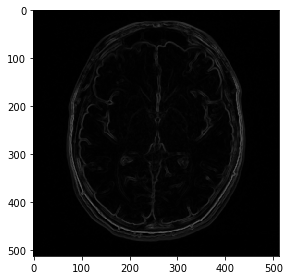

In [42]:
output_image = io.imread("output/final_output.png")
io.imshow(output_image)

In [43]:
!monai-deploy package simple_imaging_app --tag simple_app:latest  # -l DEBUG

Building MONAI Application Package... Done
[2022-06-04 12:14:43,633] [INFO] (app_packager) - Successfully built simple_app:latest


In [44]:
!docker image ls | grep simple_app

simple_app                    latest          addbbb8a15e8   About a minute ago   15.5GB


In [45]:
# Copy a test input file to 'input' folder
!mkdir -p input && rm -rf input/*
!cp {test_input_path} input/

# Launch the app
!monai-deploy run simple_app:latest input output

Checking dependencies...
--> Verifying if "docker" is installed...

--> Verifying if "simple_app:latest" is available...

Checking for MAP "simple_app:latest" locally
"simple_app:latest" found.

Reading MONAI App Package manifest...
Going to initiate execution of operator SobelOperator
Executing operator SobelOperator (Process ID: 1, Operator ID: e62c415c-36e5-417e-8635-cee53fc76971)
[2022-06-04 10:16:12,748] [INFO] (matplotlib.font_manager) - generated new fontManager
Done performing execution of operator SobelOperator

Going to initiate execution of operator MedianOperator
Executing operator MedianOperator (Process ID: 1, Operator ID: ec400bf9-6b6d-4b29-a020-0476eca714ce)
Done performing execution of operator MedianOperator

Going to initiate execution of operator GaussianOperator
Executing operator GaussianOperator (Process ID: 1, Operator ID: fd1b7bda-638e-4a6f-90e9-ed7f640577db)
/root/.local/lib/python3.8/site-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dime

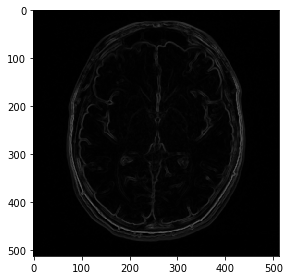

In [46]:
output_image = io.imread("output/final_output.png")
io.imshow(output_image)